In [78]:
import pandas as pd
import numpy as np
import sqlite3
import sys
from IPython.display import clear_output
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import sys

# Exploratory data analysis

In [79]:
def reformat_large_tick_values(tick_val, pos):
    """
    Turns large tick values (in the billions, millions and thousands) such as 4500 into 4.5K and also appropriately turns 4000 into 4K (no zero after the decimal).
    """
    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif tick_val >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(val)
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 1)
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)
    
    # code below will keep 4.5M as is but change values such as 4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")
    
    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]
            
    return new_tick_format

In [80]:
#Data
df = pd.read_csv('KinoPoisk_processed')
df.drop(labels='Качество видео', axis=1, inplace=True)

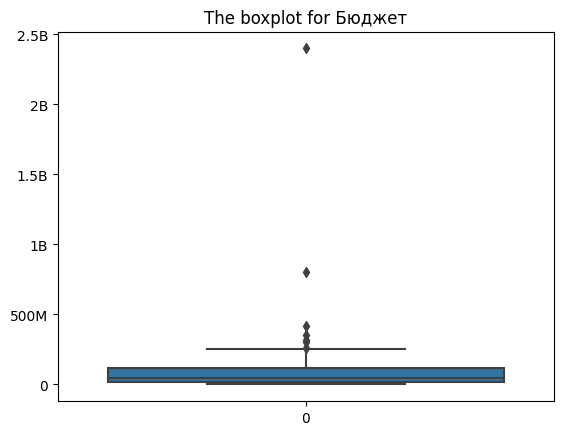

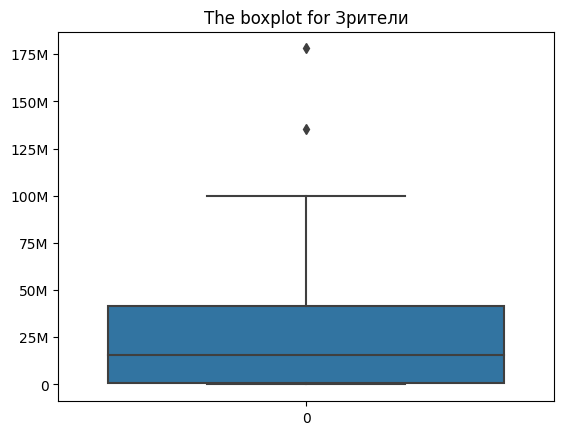

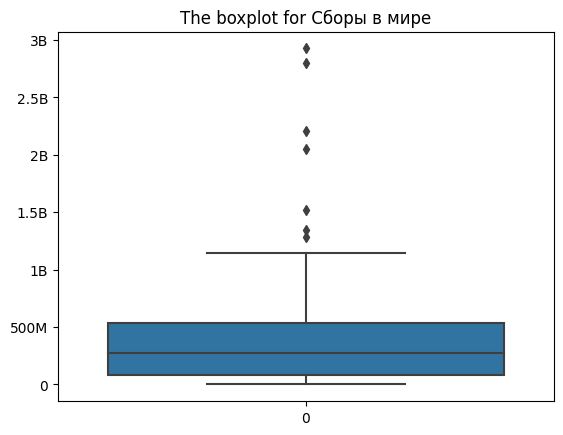

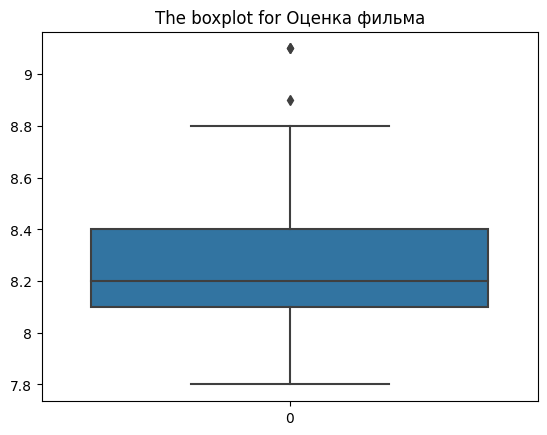

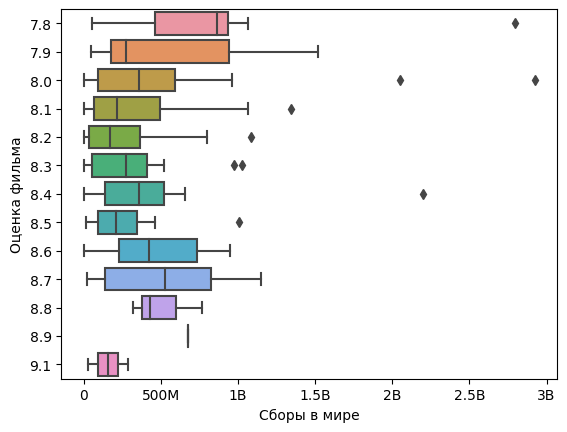

In [81]:
numeric_cols = ['Бюджет', 'Зрители', 'Сборы в мире', 'Оценка фильма']
for col in numeric_cols:
    sns.boxplot(df[col])
    ax = plt.gca()
    ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
    plt.title(f'The boxplot for {col}')
    plt.show()

sns.boxplot(x=df['Сборы в мире'], y=df['Оценка фильма'], orient='h')
ax = plt.gca()
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
plt.show()

## Part 2: Visualization

#### Histograms

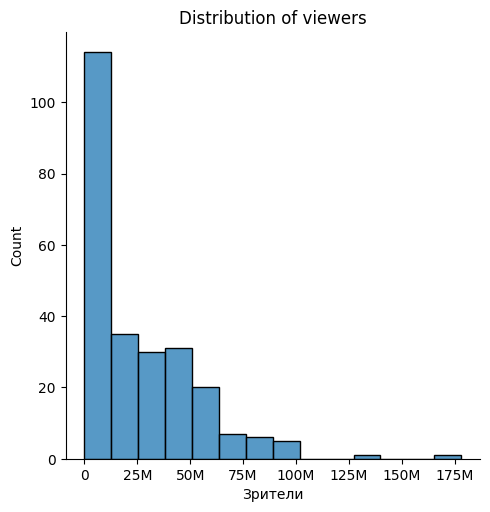

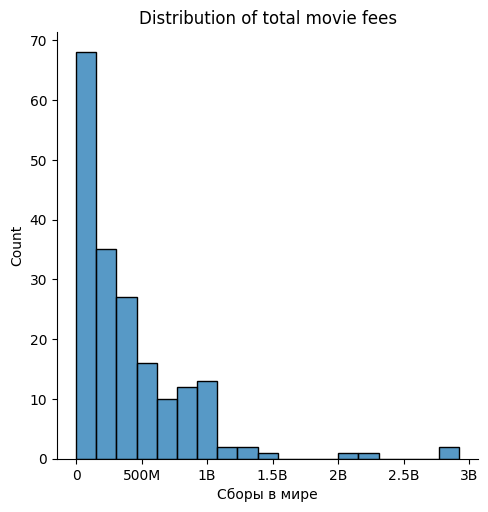

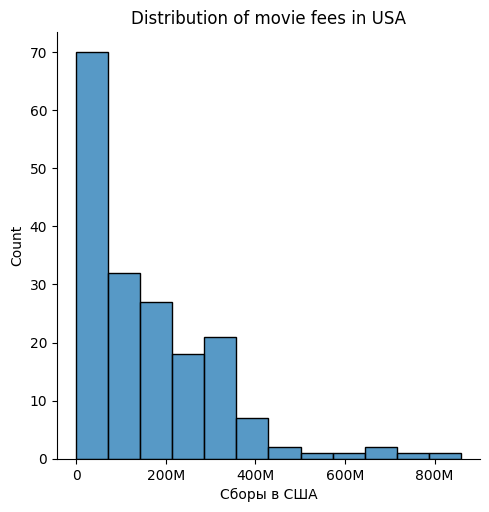

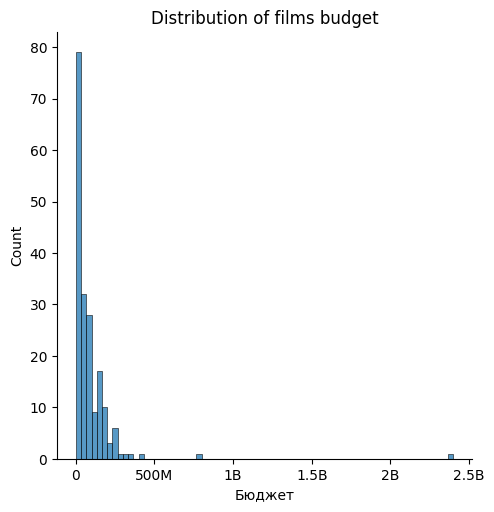

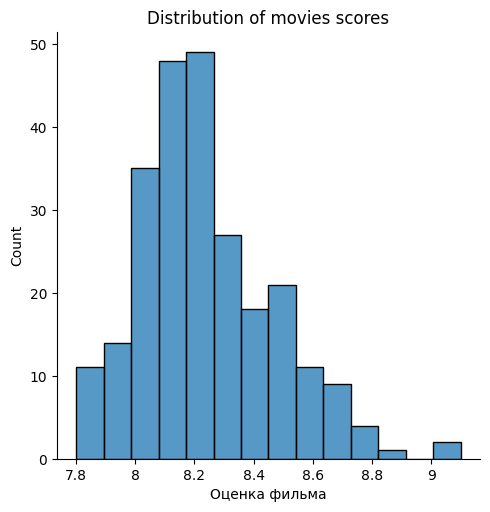

In [82]:
cols = ['Зрители', 'Сборы в мире', 'Сборы в США', 'Бюджет', 'Оценка фильма']
titles = ['Distribution of viewers', 'Distribution of total movie fees', 'Distribution of movie fees in USA', 'Distribution of films budget', 'Distribution of movies scores']
for col in cols:
    sns.displot(df[col])
    plt.title(titles[cols.index(col)])
    ax = plt.gca()
    ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
    plt.show()

### Word cloud

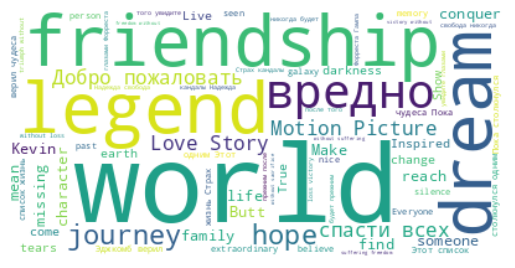

In [83]:
text = " ".join(review for review in df['Слоган'])

stopwords = set(STOPWORDS)
stopwords.update(["Beyond", "will", 'может'])
wordcloud = WordCloud(stopwords=stopwords, background_color="white", min_word_length=4, collocation_threshold=10).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## The below graphs should be created in dashboard

#### Time-series plots

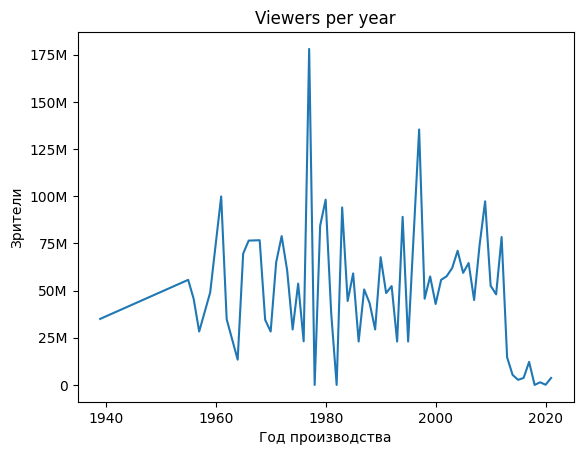

In [84]:
viewers_per_year = df.groupby('Год производства')['Зрители'].max()
sns.lineplot(viewers_per_year)
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
plt.title('Viewers per year')
plt.show()

### Categorical analysis

In [85]:
def show_values(axs, orient="v", space=0):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = reformat_large_tick_values(p.get_height(), 0)
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = reformat_large_tick_values(p.get_width(), 0)
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

In [92]:
def bar_plot(name_of_category_column, name_of_measerment_column, title_name, aggregation_func='mean', scale_of_axis=None):
    cols = name_of_category_column+': '
    if aggregation_func == 'mean':
        dictionary = {col.split(': ')[1]: df[df[col]==True][name_of_measerment_column].mean() for col in df.columns if cols in col}
    elif aggregation_func == 'median':
        dictionary = {col.split(': ')[1]: df[df[col]==True][name_of_measerment_column].median() for col in df.columns if cols in col}
    for element in dictionary.copy():
        if 'nan' in str(dictionary[element]):
            del dictionary[element]
    dictionary = dict(sorted(dictionary.items(), 
                             key=lambda x:x[1], 
                             reverse=True))
    df_small = pd.melt(pd.DataFrame(dictionary, index=[0]))
    df_small.loc[(df_small['value']/df_small['value'].sum())<0.03, 'variable'] = 'другие'
    fig = px.histogram(y=df_small['variable'], 
                       x=df_small['value'], 
                       title=title_name, 
                       text_auto='.2s')
    fig.update_layout(barmode='stack', 
                      xaxis={'categoryorder': 'total descending'}, 
                      xaxis_range=scale_of_axis)
    return fig

In [93]:
def count_plot(name_of_category_column, title_name):
    cols = name_of_category_column+': '
    dictionary = {col.split(': ')[1]: df[df[col]==True]['Название фильма'].count() for col in df.columns if cols in col}
    dictionary = dict(sorted(dictionary.items(), key=lambda x:x[1], reverse=True))
    df_small = pd.melt(pd.DataFrame(dictionary, index=[0]))
    df_small.loc[(df_small['value']/df_small['value'].sum())<0.04, 'variable'] = 'другие'
    fig = px.pie(data_frame=df_small, names=df_small['variable'], values=df_small['value'], title=title_name)
    fig.show()

#### Genre

In [94]:
count_plot(name_of_category_column='Жанр', title_name='Количество фильмов каждого жанра')
bar_plot(name_of_category_column='Жанр', name_of_measerment_column='Сборы в мире',title_name='Средние сборы фильма по жанрам в долларах')
bar_plot(name_of_category_column='Жанр', name_of_measerment_column='Сборы в США', title_name='Средние сборы фильма в США по жанрам в долларах')
bar_plot(name_of_category_column='Жанр', name_of_measerment_column='Зрители', title_name='Среднее кол-во зрителей фильма по жанрам')
#bar_plot(name_of_category_column='Жанр', name_of_measerment_column='Оценка фильма', title_name='Средняя оценка фильма по жанрам', scale_of_axis=[8,8.5])

#### Country

In [ ]:
count_plot(name_of_category_column='Страна', title_name='Кол-во фильмов по странам производства')
bar_plot(name_of_category_column='Страна', name_of_measerment_column='Сборы в мире', title_name='Средние сборы фильма в мире по странам производства')
bar_plot(name_of_category_column='Страна', name_of_measerment_column='Сборы в США', title_name='Средние сборы фильма в США по странам производства')
bar_plot(name_of_category_column='Страна', name_of_measerment_column='Зрители', title_name='Среднее кол-во зрителей по странам производства')
bar_plot(name_of_category_column='Страна', name_of_measerment_column='Оценка фильма', title_name='Средняя оценка фильмов по странам производства')

#### Producer

#### Screenwriter

#### Actors